In [1]:
import os
from functools import partial
import re
from itertools import chain

import pandas as pd
import albumentations as A
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError

from src.constants import DATA_PATH
from src.dataset import MultimodalDataset, collate_fn, get_transforms, get_ingredients_idx
from src.utils import MultimodalModel, seed_everything, train, validate, plot_images_flatten

/home/russele7/practicum/dle/sprint_4/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

# Этап 1. EDA

## 1.1 Загрузка данных

In [3]:
dish_path = f'{DATA_PATH}dish.csv'
ingredients_path = f'{DATA_PATH}ingredients.csv'

In [4]:
df_dish = pd.read_csv(dish_path)
df_ing = pd.read_csv(ingredients_path)

In [5]:
df_ing

,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes
...,...,...
550,551,pizza sauce
551,552,pomegranate
552,553,nut cheese
553,554,soy sausage


In [6]:
df_dish

,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train
...,...,...,...,...,...
3257,dish_1563295334,228.540009,96.0,ingr_0000000004;ingr_0000000008,train
3258,dish_1566329234,262.625214,457.0,ingr_0000000161;ingr_0000000189;ingr_000000000...,train
3259,dish_1562691737,485.676880,700.0,ingr_0000000543;ingr_0000000027;ingr_000000012...,train
3260,dish_1558458496,53.130001,77.0,ingr_0000000440,train


## 1.2 Визуализация данных

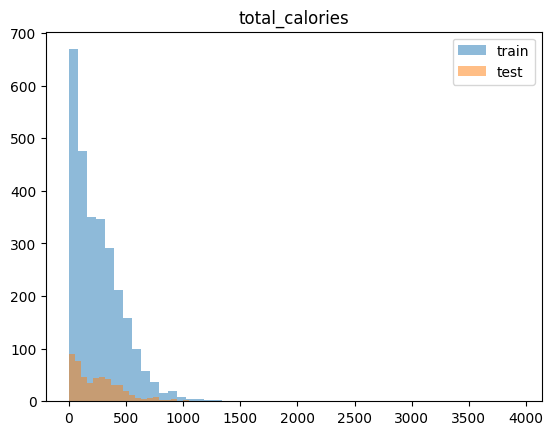

In [7]:
plt.hist(df_dish[df_dish['split'] == 'train']['total_calories'], bins=50, alpha=0.5, label='train')
plt.hist(df_dish[df_dish['split'] == 'test']['total_calories'], bins=20, alpha=0.5, label='test')
plt.title('total_calories')
plt.legend()

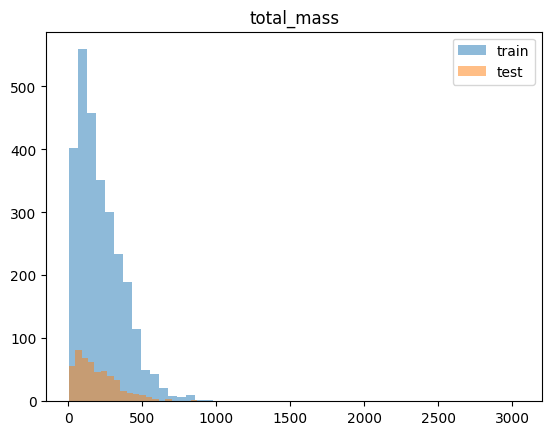

In [8]:
plt.hist(df_dish[df_dish['split'] == 'train']['total_mass'], bins=50, alpha=0.5, label='train')
plt.hist(df_dish[df_dish['split'] == 'test']['total_mass'], bins=20, alpha=0.5, label='test')
plt.title('total_mass')
plt.legend()

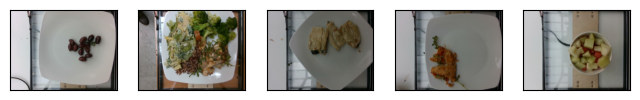

In [9]:
plot_images_flatten(df_dish['dish_id'])

## 1.3 Обработка текстового описания - переход к токенам. (при обучении модели данные операции будут проходить "под капотом")

In [10]:
dict_ingredients = {k:v for k, v in zip(df_ing['id'], df_ing['ingr'])}
dict_ingredients

{1: 'cottage cheese',
 2: 'strawberries',
 3: 'garden salad',
 4: 'bacon',
 5: 'potatoes',
 6: 'caesar salad',
 7: 'cauliflower',
 8: 'scrambled eggs',
 9: 'wild rice',
 10: 'steak',
 11: 'cheese pizza',
 12: 'olives',
 13: 'berries',
 14: 'asparagus',
 15: 'hash browns',
 16: 'brussels sprouts',
 17: 'pasta salad',
 18: 'turkey',
 19: 'bread',
 20: 'duck',
 21: 'squash',
 22: 'guacamole',
 23: 'brown rice',
 24: 'artic char',
 25: 'beef',
 26: 'white rice',
 27: 'broccoli',
 28: 'chicken',
 29: 'mixed greens',
 30: 'lettuce',
 31: 'cucumbers',
 32: 'tomatoes',
 33: 'bell peppers',
 34: 'celery',
 35: 'blue cheese',
 36: 'spinach (raw)',
 37: 'cantaloupe',
 38: 'pineapple',
 39: 'sausage',
 40: 'raspberries',
 41: 'blackberries',
 42: 'avocado',
 43: 'green beans',
 44: 'bean sprouts',
 45: 'carrot',
 46: 'mushroom',
 47: 'corn',
 48: 'ham',
 49: 'fish',
 50: 'tofu',
 51: 'shrimp',
 52: 'cheese',
 53: 'nuts',
 54: 'apple',
 55: 'banana',
 56: 'kiwi',
 57: 'lemon',
 58: 'orange',
 59: '

In [11]:
df_dish['ingredients_idx'] = df_dish['ingredients'].apply(lambda x: get_ingredients_idx(x))

In [12]:
df_dish.head()

,dish_id,total_calories,total_mass,ingredients,split,ingredients_idx
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test,"[508, 122, 26, 524, 94, 23, 189, 54, 29, 328, ..."
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train,"[312, 26, 29, 122, 508, 513, 520, 525, 161, 94..."
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test,"[448, 520, 462, 514, 152, 312, 291, 45, 122, 6..."
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train,"[471, 31, 347]"
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train,[453]


## 1.4 Сформируйте видение
- Как решать задачу: Мультимодальная нейросеть. Картинка + текст + масса блюда
- какие подходы к обогащению/аугментации данных примените и почему: 
    - Изображения - аффинные повороты, яркость-контрастность-насыщенность-оттенки, размытие, шум. После этих обработок не нарушается концепция изображения, и компоненты все еще можно разглядеть
    - Тексты: аугментация за счет перестановки токенов. Т.к. порядок перечисления компонентов не важен
### 
- на какие метрики будете ориентироваться при обучении: MAE, MSE, MAPE

# Этап 2. Реализуйте пайплайн обучения

## 2.1 Загрузчики данных и датасеты

In [13]:
# Реализовано в src

## 2.2 Опциональный код предобработки/аугментации данных

In [14]:
# Реализовано в src

## 2.3 Код обучения и валидации для импортирования в виде одной функции

In [15]:
# Реализовано в src

## 2.4 Конфиг-файл для запуска модели и сохранения результатов обучения

In [ ]:
class Config:
    SEED = 42

    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"

    BATCH_SIZE = 16 #256
    TEXT_LR = 3e-5
    IMAGE_LR = 1e-4
    REGRESSOR_LR = 1e-3
    EPOCHS = 12 #30
    DROPOUT = 0.2
    HIDDEN_DIM = 256

    SAVE_PATH = "models/best_model.pth"

In [17]:
config = Config()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
device

'cuda'

## 2.5 Код для получения воспроизводимых результатов (seed) с выводом метрик

In [19]:
# Реализовано в src

# Этап 3. Обучение модели

## 3.1 Вызов метода обучения с передачей конфига

In [20]:
train(config, device)

Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.11.output.dense.weight
Разморожен слой: encoder.layer.11.output.dense.bias
Разморожен слой: encoder.layer.11.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.output.LayerNorm.bias
Разморожен слой: pooler.dense.weight
Раз

  0%|          | 0/204 [00:00<?, ?it/s]/home/russele7/practicum/dle/sprint_4/practicum_dle_sprint_4/src/utils.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_features = torch.tensor(mass_input).unsqueeze(1)
100%|██████████| 204/204 [01:27<00:00,  2.33it/s]


Epoch 0/19 | avg_Loss: 232.6478 | Train MAE: 232.6636| Val MAE: 211.4244
New best model, epoch: 0
epoch 1


100%|██████████| 204/204 [01:23<00:00,  2.45it/s]


Epoch 1/19 | avg_Loss: 187.0717 | Train MAE: 187.1231| Val MAE: 162.1764
New best model, epoch: 1
epoch 2


100%|██████████| 204/204 [01:26<00:00,  2.37it/s]


Epoch 2/19 | avg_Loss: 143.3546 | Train MAE: 143.3882| Val MAE: 123.5010
New best model, epoch: 2
epoch 3


100%|██████████| 204/204 [01:23<00:00,  2.46it/s]


Epoch 3/19 | avg_Loss: 109.5948 | Train MAE: 109.6296| Val MAE: 93.9882
New best model, epoch: 3
epoch 4


100%|██████████| 204/204 [01:25<00:00,  2.39it/s]


Epoch 4/19 | avg_Loss: 87.4571 | Train MAE: 87.4446| Val MAE: 81.2474
New best model, epoch: 4
epoch 5


100%|██████████| 204/204 [01:25<00:00,  2.37it/s]


Epoch 5/19 | avg_Loss: 74.8518 | Train MAE: 74.8197| Val MAE: 65.0989
New best model, epoch: 5
epoch 6


100%|██████████| 204/204 [01:23<00:00,  2.45it/s]


Epoch 6/19 | avg_Loss: 66.5233 | Train MAE: 66.4932| Val MAE: 62.5599
New best model, epoch: 6
epoch 7


100%|██████████| 204/204 [01:23<00:00,  2.46it/s]


Epoch 7/19 | avg_Loss: 62.9809 | Train MAE: 62.9972| Val MAE: 54.2513
New best model, epoch: 7
epoch 8


100%|██████████| 204/204 [01:25<00:00,  2.39it/s]


Epoch 8/19 | avg_Loss: 59.1413 | Train MAE: 59.1554| Val MAE: 55.4875
epoch 9


100%|██████████| 204/204 [01:20<00:00,  2.54it/s]


Epoch 9/19 | avg_Loss: 55.4157 | Train MAE: 55.4190| Val MAE: 49.4667
New best model, epoch: 9
epoch 10


100%|██████████| 204/204 [01:20<00:00,  2.54it/s]


Epoch 10/19 | avg_Loss: 53.1907 | Train MAE: 53.1952| Val MAE: 49.0349
New best model, epoch: 10
epoch 11


100%|██████████| 204/204 [01:23<00:00,  2.45it/s]


Epoch 11/19 | avg_Loss: 51.8813 | Train MAE: 51.8794| Val MAE: 46.0485
New best model, epoch: 11
epoch 12


100%|██████████| 204/204 [01:20<00:00,  2.54it/s]


Epoch 12/19 | avg_Loss: 50.5698 | Train MAE: 50.5814| Val MAE: 43.1856
New best model, epoch: 12
epoch 13


100%|██████████| 204/204 [01:23<00:00,  2.45it/s]


Epoch 13/19 | avg_Loss: 48.1452 | Train MAE: 48.1330| Val MAE: 44.0473
epoch 14


100%|██████████| 204/204 [01:22<00:00,  2.47it/s]


Epoch 14/19 | avg_Loss: 47.8197 | Train MAE: 47.8149| Val MAE: 41.1476
New best model, epoch: 14
epoch 15


100%|██████████| 204/204 [01:26<00:00,  2.37it/s]


Epoch 15/19 | avg_Loss: 47.1886 | Train MAE: 47.1969| Val MAE: 39.1662
New best model, epoch: 15
epoch 16


100%|██████████| 204/204 [01:23<00:00,  2.46it/s]


Epoch 16/19 | avg_Loss: 45.5789 | Train MAE: 45.5766| Val MAE: 37.3414
New best model, epoch: 16
epoch 17


100%|██████████| 204/204 [01:22<00:00,  2.46it/s]


Epoch 17/19 | avg_Loss: 45.2679 | Train MAE: 45.2573| Val MAE: 36.9150
New best model, epoch: 17
epoch 18


100%|██████████| 204/204 [01:26<00:00,  2.35it/s]


Epoch 18/19 | avg_Loss: 44.4954 | Train MAE: 44.5035| Val MAE: 37.9092
epoch 19


100%|██████████| 204/204 [01:22<00:00,  2.46it/s]


Epoch 19/19 | avg_Loss: 43.8926 | Train MAE: 43.8995| Val MAE: 37.3055


# Этап 4. Валидация

## 4.1 Расчет целевой метрики на тестовом датасете

In [21]:
model = MultimodalModel(config)
model.load_state_dict(torch.load(config.SAVE_PATH))
model = model.to(device)

tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL_NAME)

val_transforms = get_transforms(config, mode="test")
val_dataset = MultimodalDataset(config, val_transforms, mode="test")
val_loader = DataLoader(val_dataset,
                        batch_size=config.BATCH_SIZE,
                        shuffle=False,
                        collate_fn=partial(collate_fn,
                        tokenizer=tokenizer,
                        mode="test"))

In [22]:
mae_valid = validate(model, val_loader, device, MeanAbsoluteError().to(device))
mape_valid = validate(model, val_loader, device, MeanAbsolutePercentageError().to(device))
mse_valid = validate(model, val_loader, device, MeanSquaredError().to(device))

  0%|          | 0/204 [00:00<?, ?it/s]/home/russele7/practicum/dle/sprint_4/practicum_dle_sprint_4/src/utils.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_features = torch.tensor(mass_input).unsqueeze(1)
100%|██████████| 204/204 [01:23<00:00,  2.43it/s]


In [23]:
print(f'MAE on TEST = {mae_valid}\n'
      f'MSE on TEST = {mse_valid}\n'
      f'MAPE on TEST = {mape_valid}\n')

MAE on TEST = 36.91501235961914
MSE on TEST = 8063.8681640625
MAPE on TEST = 13556.2060546875



## 4.2 Выведите топ-5 блюд, по которым оценка модели наименее точна. Опишите возможные причины низкого качества на этих примерах.

In [24]:
y_true, y_predict = [], []
dish_list = []
with torch.no_grad():
    for batch in tqdm(val_loader):

        inputs = {
            'text_input': {'input_ids': batch['input_ids'].to(device),
                            'attention_mask': batch['attention_mask'].to(device)},
            'image_input': batch['image'].to(device),
            'mass_input': batch['total_mass'].to(device)
        }

        targets = batch['target'].to(device)

        dish_ids = batch['dish_id']

        preds = model(**inputs).squeeze()

        y_true.append(targets.to('cpu').numpy())
        y_predict.append(preds.to('cpu').numpy())
        dish_list.append(dish_ids)

y_true = np.concatenate(y_true)
y_predict = np.concatenate(y_predict)
dish_list = list(chain(*dish_list))

100%|██████████| 204/204 [01:57<00:00,  1.74it/s]


In [25]:
df = pd.DataFrame({'dish_id': dish_list,'y_true': y_true, 'y_predict': y_predict})
df['abs_delta'] = abs(df['y_true'] - df['y_predict'])
df = df.sort_values('abs_delta', ascending=False)

In [35]:
df

,dish_id,y_true,y_predict,abs_delta
1518,dish_1560974769,3943,628.886414,3314.113586
1326,dish_1562173111,792,88.048889,703.951111
124,dish_1565033265,1324,621.526001,702.473999
1125,dish_1564170010,1264,620.250610,643.749390
2753,dish_1562603895,1268,648.333069,619.666931
...,...,...,...,...
1387,dish_1561666619,35,35.048088,0.048088
2687,dish_1558722370,19,18.954300,0.045700
2726,dish_1559674781,81,81.045273,0.045273
2379,dish_1561146758,232,232.040771,0.040771


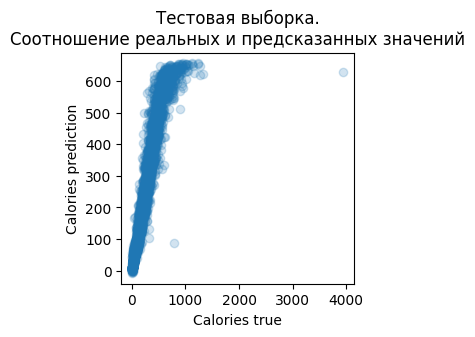

In [59]:
plt.figure(figsize=(3, 3))
plt.scatter(x=df['y_true'], y=df['y_predict'], alpha=0.2)
plt.xlabel('Calories true')
plt.ylabel('Calories prediction')
plt.title('Тестовая выборка.\nСоотношение реальных и предсказанных значений')
plt.show()

In [52]:
df_tmp = df[abs(df['y_true']) < 1500]

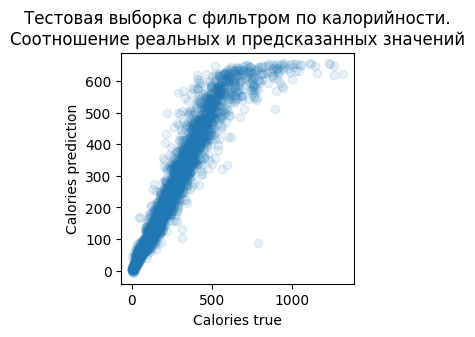

In [56]:
plt.figure(figsize=(3, 3))
plt.scatter(x=df_tmp['y_true'], y=df_tmp['y_predict'], alpha=0.1)
plt.xlabel('Calories true')
plt.ylabel('Calories prediction')
plt.title('Тестовая выборка с фильтром по калорийности.\nСоотношение реальных и предсказанных значений')
plt.show()

ТОП 5 блюд с наихудшим предсказанием


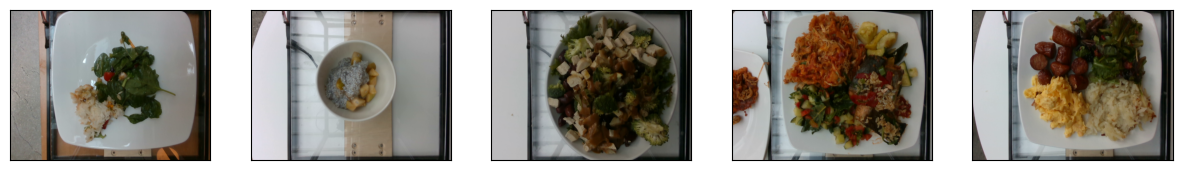

In [33]:
print(f'ТОП 5 блюд с наихудшим предсказанием')
plot_images_flatten(df['dish_id'][:5], sample_flg=False, figsize=(15, 15))

ТОП 5 блюд с наилучшим предсказанием


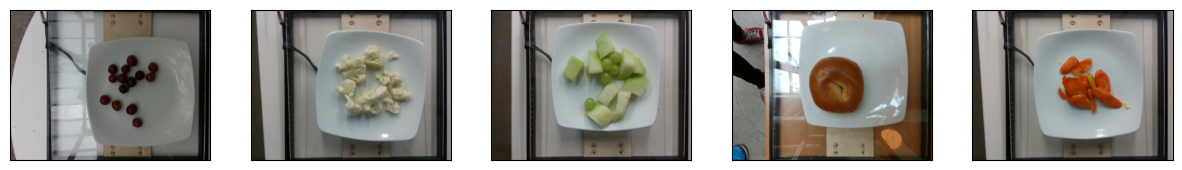

In [34]:
print(f'ТОП 5 блюд с наилучшим предсказанием')
plot_images_flatten(df['dish_id'][-5:], sample_flg=False, figsize=(15, 15))

### Причины низких предсказаний - много ингредиентов в одном блюде; тарелка на большом расстоянии (занимает мало места на картинке)